<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-Preparation" data-toc-modified-id="Data-Preparation-1">Data Preparation</a></span><ul class="toc-item"><li><span><a href="#Load-Datasets" data-toc-modified-id="Load-Datasets-1.1">Load Datasets</a></span></li><li><span><a href="#Merge-Datasets" data-toc-modified-id="Merge-Datasets-1.2">Merge Datasets</a></span></li></ul></li><li><span><a href="#Data-Cleaning" data-toc-modified-id="Data-Cleaning-2">Data Cleaning</a></span></li><li><span><a href="#Exploratory-Data-Analysis" data-toc-modified-id="Exploratory-Data-Analysis-3">Exploratory Data Analysis</a></span><ul class="toc-item"><li><span><a href="#Correlation-Matrix" data-toc-modified-id="Correlation-Matrix-3.1">Correlation Matrix</a></span></li></ul></li><li><span><a href="#Statistical-Tests" data-toc-modified-id="Statistical-Tests-4">Statistical Tests</a></span></li><li><span><a href="#Feature-Engineering" data-toc-modified-id="Feature-Engineering-5">Feature Engineering</a></span><ul class="toc-item"><li><span><a href="#Dummy-Encoding" data-toc-modified-id="Dummy-Encoding-5.1">Dummy Encoding</a></span></li></ul></li><li><span><a href="#Machine-Learning-Prediction" data-toc-modified-id="Machine-Learning-Prediction-6">Machine Learning Prediction</a></span><ul class="toc-item"><li><span><a href="#Decision-Tree" data-toc-modified-id="Decision-Tree-6.1">Decision Tree</a></span></li><li><span><a href="#Random-Forest" data-toc-modified-id="Random-Forest-6.2">Random Forest</a></span></li></ul></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-7">Conclusion</a></span></li></ul></div>

# Data Preparation

In [1]:
# import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from ast import literal_eval

## Load Datasets

In [2]:
# Read the datasets with movie features
metadata = pd.read_csv('/Users/dorislin/Desktop/movie rating predictor/the-movies-dataset/movies_metadata.csv', dtype={'popularity': object})
credits =  pd.read_csv('/Users/dorislin/Desktop/movie rating predictor/the-movies-dataset/credits.csv')
keywords =  pd.read_csv('/Users/dorislin/Desktop/movie rating predictor/the-movies-dataset/keywords.csv')

In [3]:
# Read the rating datasets
ratings = pd.read_csv('/Users/dorislin/Desktop/movie rating predictor/the-movies-dataset/ratings.csv')
links = pd.read_csv('/Users/dorislin/Desktop/movie rating predictor/the-movies-dataset/links.csv')

## Merge Datasets

Movie features are stored in 'metadata','credits', and 'keywords' datasets; while the rating records are in 'ratings' and 'links'. Before merging them into one single DataFrame, I computed the target variable, 'weighted_rating', from the average rating score and audience number first.

In [4]:
# Handle misplaced 'id' values 

# Swap incorrect values between 'id' and 'release_date'
swap_condition = metadata['id'].str.contains('-') == True
ary = np.where(swap_condition,[metadata.release_date,metadata.id],[metadata.id,metadata.release_date])
metadata.id = ary[0]
metadata.release_date = ary[1]
# Convert the data type of 'id' from string to int
metadata['id'] = metadata['id'].astype(int)

# Merge datasets with movie features with the key colum 'id'
movie = metadata.merge(credits.merge(keywords, on='id'), on='id')

### Computing 'weighted_rating' as the target variable

Using IMDB weighted rating function
`(WR) = (v ÷ (v+m)) × R + (m ÷ (v+m)) × C`

wehre: 
- v: number of votes for each movie
- m: the minimum votes required to be listed in the chart
- R: average rating for each movie
- C: the mean rating of overall movies

In [5]:
# Initial Examination
ratings.head()

,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
3,1,1221,5.0,1425941546
4,1,1246,5.0,1425941556


Same movie occurs repeatedly becuas each row represents a rating record by one audience.

In [6]:
# Comput average rating and number of votes as the formula needed
ratings['average_rating'] = ratings.groupby('movieId')['rating'].transform(np.mean)
ratings['votes_per_movie'] = ratings.groupby('movieId')['userId'].transform('count')

In [7]:
# Now movies rated by differenet audience yet shared the same tmdbID has the same averate rating and vote numbers
# Drop irrelevant data and remove duplicates
ratings = ratings.merge(links, on='movieId')
ratings = ratings.drop_duplicates('tmdbId')[['tmdbId','votes_per_movie','average_rating']]
ratings = ratings.loc[pd.notnull(ratings['tmdbId']) != False]

In [8]:
# m: the minumum votes required to be listed in the chart
m = ratings['votes_per_movie'].quantile(0.75)
m

69.0

In [9]:
# C: the mean rating across the whole report
C = ratings['average_rating'].mean()
C

3.061092348429485

In [10]:
# filter the movies qualified for the chart
ratings = ratings[ratings['votes_per_movie'] >= m]

In [11]:
# Compute weighted_rating
def weighted_rating(x):
    """Use IMDB formula to compute weighted rating"""
    v = x['votes_per_movie']
    R = x['average_rating']
    return (v/(v+m) * R) + (m/(m+v) * C)
ratings.loc[:,'weighted_rating'] = ratings.apply(weighted_rating, axis=1)

In [12]:
ratings = ratings.astype({'tmdbId': 'int64'})
# Merge raings with movie
df = pd.merge(movie, ratings, how = 'inner', left_on = 'id', right_on = 'tmdbId')

# Data Cleaning

In [13]:
# Get an initial feeling of the data
df.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,video,vote_average,vote_count,cast,crew,keywords,tmdbId,votes_per_movie,average_rating,weighted_rating
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,False,7.7,5415.0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...",862,66008,3.888157,3.887294
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,False,6.9,2413.0,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[{'id': 10090, 'name': 'board game'}, {'id': 1...",8844,26060,3.236953,3.236489
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,False,6.5,92.0,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[{'id': 1495, 'name': 'fishing'}, {'id': 12392...",15602,15497,3.175550,3.175043
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,False,6.1,34.0,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...","[{'id': 818, 'name': 'based on novel'}, {'id':...",31357,2981,2.875713,2.879907
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,False,5.7,173.0,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...","[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n...",11862,15258,3.079565,3.079482


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11366 entries, 0 to 11365
Data columns (total 31 columns):
adult                    11366 non-null object
belongs_to_collection    2016 non-null object
budget                   11366 non-null object
genres                   11366 non-null object
homepage                 2607 non-null object
id                       11366 non-null int64
imdb_id                  11365 non-null object
original_language        11366 non-null object
original_title           11366 non-null object
overview                 11360 non-null object
popularity               11365 non-null object
poster_path              11363 non-null object
production_companies     11366 non-null object
production_countries     11366 non-null object
release_date             11365 non-null object
revenue                  11364 non-null float64
runtime                  11364 non-null float64
spoken_languages         11364 non-null object
status                   11360 non-null object

**Thought Process**
1. Identify columns that fit to the objectives of this project and remove irrelevant ones:
  - `identifiers`
    - id
    - title
  - `business-side`
    -   revenue
    -   budget
  - `plot`
    - belongs_to_collection
    - genres
    - keywords
  - `production-side`
    - runtime
    - release_date
    - original_language
    - production_companies
    - production_countries
  - `team`
    - cast
    - crew
  - `audience`
    - votes_per_movie

  - `target variable`
    - weighted_rating
    

2. Know which parts require detection of missing values and type conversion.

### Remove Duplicates and Irrelevant Data

In [15]:
# Remove the duplicates with identical values of 'id'
df = df.drop_duplicates('id', keep = 'first')

In [16]:
# Drop irrelevant data
to_keep_features = ['id','title','revenue','budget','belongs_to_collection','genres','keywords','runtime','release_date',
                   'original_language','production_companies','production_countries','cast','crew', 'votes_per_movie','weighted_rating']
df = df[to_keep_features]

In [17]:
print ('The shape of dataset:',df.shape)
print ('Columns include:',list(df.columns))

The shape of dataset: (11232, 16)
Columns include: ['id', 'title', 'revenue', 'budget', 'belongs_to_collection', 'genres', 'keywords', 'runtime', 'release_date', 'original_language', 'production_companies', 'production_countries', 'cast', 'crew', 'votes_per_movie', 'weighted_rating']


### Detect Missing Data

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11232 entries, 0 to 11365
Data columns (total 16 columns):
id                       11232 non-null int64
title                    11232 non-null object
revenue                  11232 non-null float64
budget                   11232 non-null object
belongs_to_collection    1995 non-null object
genres                   11232 non-null object
keywords                 11232 non-null object
runtime                  11232 non-null float64
release_date             11231 non-null object
original_language        11232 non-null object
production_companies     11232 non-null object
production_countries     11232 non-null object
cast                     11232 non-null object
crew                     11232 non-null object
votes_per_movie          11232 non-null int64
weighted_rating          11232 non-null float64
dtypes: float64(3), int64(2), object(11)
memory usage: 1.5+ MB


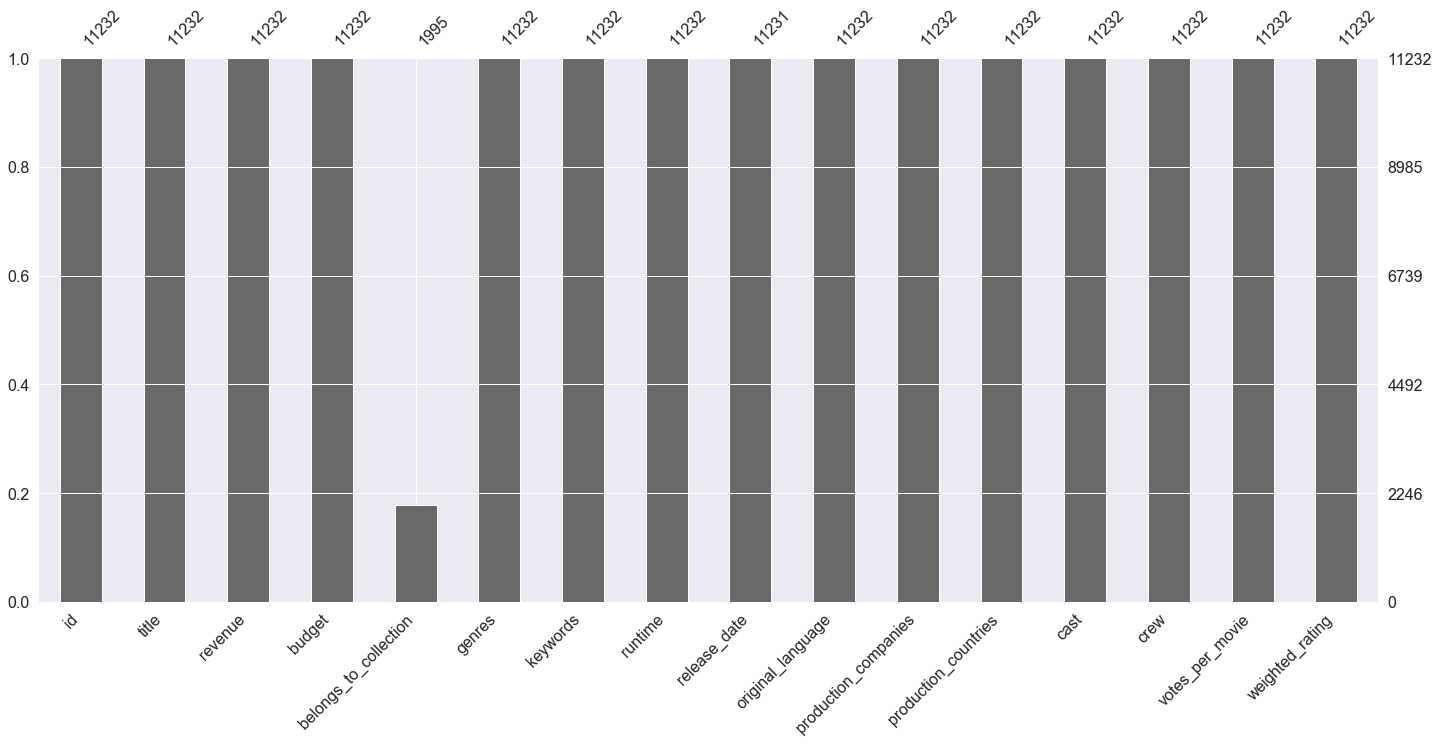

In [19]:
import missingno as msno
msno.bar(df)

**Thought Process**
1. Besides of 'belongs_to_collection' column, no obvious missing values observed. 
2. However, I found nonstandard missing values in column 'budget' and 'revenue' when looking closer into the data.

### Handling Missing data
After examination, I found that missing values in 'belongs_to_collection' indicate the movie has no sequence.

I used boolean logic to separate movies into two categories: belonging to a collection or without sequence, and compute 1 and 0 to them accordinly.

In [20]:
# Compute 0 for missing values (the movies without sequence)
df['belongs_to_collection'].fillna(0, inplace = True)
# Compute 1 for belonging to a collection
condition = df['belongs_to_collection'] != 0
df.loc[condition, 'belongs_to_collection'] = 1

### Nonstandard Missing data

In [21]:
# Closer look at observations with zero budget
df[df['budget'] == '0'].sample(5)

,id,title,revenue,budget,belongs_to_collection,genres,keywords,runtime,release_date,original_language,production_companies,production_countries,cast,crew,votes_per_movie,weighted_rating
7657,67,Paradise Now,3357075.0,0,0,"[{'id': 53, 'name': 'Thriller'}, {'id': 80, 'n...","[{'id': 30, 'name': 'individual'}, {'id': 321,...",90.0,2005-02-14,en,"[{'name': 'Lama Films', 'id': 15}, {'name': 'A...","[{'iso_3166_1': 'PS', 'name': 'Palestinian Ter...","[{'cast_id': 7, 'character': 'Khaled', 'credit...","[{'credit_id': '52fe4213c3a36847f8001df3', 'de...",444,3.653441
8366,4953,Be Kind Rewind,0.0,0,0,"[{'id': 18, 'name': 'Drama'}, {'id': 35, 'name...","[{'id': 2249, 'name': 'camcorder'}, {'id': 329...",102.0,2008-01-20,en,"[{'name': 'New Line Cinema', 'id': 12}, {'name...","[{'iso_3166_1': 'US', 'name': 'United States o...","[{'cast_id': 12, 'character': 'Jerry', 'credit...","[{'credit_id': '52fe43e7c3a36847f80773d5', 'de...",2113,3.175397
7623,13994,Romance & Cigarettes,2945242.0,0,0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10402, '...","[{'id': 1326, 'name': 'infidelity'}, {'id': 46...",105.0,2005-09-13,en,"[{'name': 'United Artists', 'id': 60}]","[{'iso_3166_1': 'US', 'name': 'United States o...","[{'cast_id': 1, 'character': 'Nick Murder', 'c...","[{'credit_id': '52fe45c09251416c75061363', 'de...",76,2.970451
5732,27117,Sherlock Holmes and the Voice of Terror,0.0,0,1,"[{'id': 18, 'name': 'Drama'}, {'id': 9648, 'na...","[{'id': 74, 'name': 'germany'}, {'id': 9401, '...",65.0,1942-09-18,en,"[{'name': 'Universal Pictures', 'id': 33}]","[{'iso_3166_1': 'US', 'name': 'United States o...","[{'cast_id': 1, 'character': 'Sherlock Holmes'...","[{'credit_id': '52fe452ec3a368484e04cda7', 'de...",80,3.202788
2487,52366,Lucie Aubrac,458557.0,0,0,"[{'id': 18, 'name': 'Drama'}]",[],115.0,1997-02-26,fr,"[{'name': 'D.A. Films', 'id': 6541}, {'name': ...","[{'iso_3166_1': 'FR', 'name': 'France'}]","[{'cast_id': 4, 'character': 'Lucie Aubrac', '...","[{'credit_id': '52fe4827c3a36847f815a4ad', 'de...",184,3.226148


In [22]:
# get the number of zero budget and zero revenue
print ('rows with zero budget:', df[df.budget == '0'].shape[0])
print ('rows with zero revenue:',df[df.revenue == 0].shape[0])

rows with zero budget: 5659
rows with zero revenue: 5529


**Thought Process**
1. Movies with zero budget often have zero revenue. Some of the movies are made by big companies, such as Warner Bros. and Columbia Pictures Corporation. Thus, zero in 'budget' and 'revenue' are more likely to represent missing values instead of low budget. 


2. Considering the cost of acquiring other data to compute missing values, and the potential bias caused by large volumns of zero, I decided to remove them from the dataset.

In [23]:
# Drop the row where revenue and budget both equal to 0
df = df[(df['budget'] != '0') & (df['revenue']!=0)].reset_index(drop = True)
print ("The shape of dataset",df.shape)

The shape of dataset (4519, 16)


### Convert Data Type

In [24]:
# convert'budget' column from object to integer data type
df['budget'] = df['budget'].astype('int64')

### Extract Nested Values
Columns including 'genres', 'procudtion_countries', 'production_companies', 'cast' and 'crew' are stored in JSON format. 

In [25]:
# extract director from the crew colum
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
df['director'] = df['crew'].apply(literal_eval).apply(get_director)
df.drop(columns=['crew'], inplace = True)

In [26]:
# Extract the main production country
df.production_countries = df.production_countries.fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
df.production_countries = df.production_countries.apply(lambda x: "" if len(x) == 0 else x[0])

In [27]:
# Extract the main production company
df.production_companies = df.production_companies.fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
df.production_companies = df.production_companies.apply(lambda x: "" if len(x) == 0 else x[0])

In [28]:
# Convert cast and only get the top 3 actors/actess
df.cast = df.cast.apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
df.cast = df.cast.apply(lambda x: x[:3] if len(x) >=3 else x)

In [29]:
# Convert genres
df.genres = df.genres.apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [30]:
# Convert keywords
df.keywords = df.keywords.apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [31]:
# Rename the column
col_name = {'belongs_to_collection':'is_collection'}
df.rename(columns= col_name, inplace = True)

### Create New Variables

In [32]:
# Convert 'release_date' to datetime object 
df['release_date'] = pd.to_datetime(df['release_date'])

# Extract the 'month' and 'year' from 'release_date'
# Replace missing values with zero
df['month'] = df['release_date'].dt.month.astype(np.int64)
df['year'] = df['release_date'].dt.year.astype(np.int64)
df.drop(labels = 'release_date', axis = 1, inplace = True)

In [33]:
# Create two feautres, 'is_adapted' and 'is_YA', based on the keywords information

def is_adapted(series):
    adapted = ['based on novel',"based on children's book"]
    for i in adapted:
        if i in series:
            return 1
    return 0
df['is_adapted'] = df['keywords'].apply(is_adapted)
def is_YA(series):
    if 'teenager' in series:
        return 1
    else:
        return 0

df['is_YA'] = df['keywords'].apply(is_YA)

# Drop keywords column
df.drop(columns=['keywords'], inplace = True)

In [34]:
df.head()

,id,title,revenue,budget,is_collection,genres,runtime,original_language,production_companies,production_countries,cast,votes_per_movie,weighted_rating,director,month,year,is_adapted,is_YA
0,862,Toy Story,373554033.0,30000000,1,"[Animation, Comedy, Family]",81.0,en,Pixar Animation Studios,United States of America,"[Tom Hanks, Tim Allen, Don Rickles]",66008,3.887294,John Lasseter,10,1995,0,0
1,8844,Jumanji,262797249.0,65000000,0,"[Adventure, Fantasy, Family]",104.0,en,TriStar Pictures,United States of America,"[Robin Williams, Jonathan Hyde, Kirsten Dunst]",26060,3.236489,Joe Johnston,12,1995,1,0
2,31357,Waiting to Exhale,81452156.0,16000000,0,"[Comedy, Drama, Romance]",127.0,en,Twentieth Century Fox Film Corporation,United States of America,"[Whitney Houston, Angela Bassett, Loretta Devine]",2981,2.879907,Forest Whitaker,12,1995,1,0
3,949,Heat,187436818.0,60000000,0,"[Action, Crime, Drama, Thriller]",170.0,en,Regency Enterprises,United States of America,"[Al Pacino, Robert De Niro, Val Kilmer]",27895,3.839837,Michael Mann,12,1995,0,0
4,9091,Sudden Death,64350171.0,35000000,0,"[Action, Adventure, Thriller]",106.0,en,Universal Pictures,United States of America,"[Jean-Claude Van Damme, Powers Boothe, Dorian ...",4423,3.009175,Peter Hyams,12,1995,0,0


In [35]:
list(df.columns)

['id',
 'title',
 'revenue',
 'budget',
 'is_collection',
 'genres',
 'runtime',
 'original_language',
 'production_companies',
 'production_countries',
 'cast',
 'votes_per_movie',
 'weighted_rating',
 'director',
 'month',
 'year',
 'is_adapted',
 'is_YA']

# Exploratory Data Analysis

### What's the frequency distribution of weighted rating per movie?

In [36]:
import statsmodels.api as sm
import scipy 

count    4519.000000
mean        3.240089
std         0.451340
min         1.263068
25%         2.946566
50%         3.261715
75%         3.565416
max         4.427979
Name: weighted_rating, dtype: float64

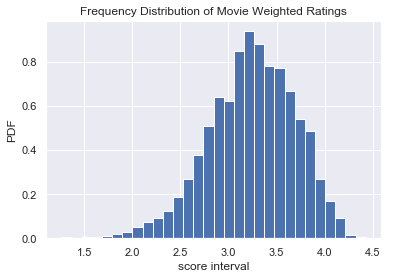

In [37]:
# plot a histogram to show the frequency distribution of weighted rating per movie
df['weighted_rating'].hist(bins=30, density = True) 
plt.title('Frequency Distribution of Movie Weighted Ratings')
plt.xlabel('score interval')
plt.ylabel('PDF')
df.weighted_rating.describe()

In [38]:
# Top 10 highly-scored movies
df[['title','weighted_rating','votes_per_movie']].sort_values(by = 'weighted_rating', ascending=False)[:10]

,title,weighted_rating,votes_per_movie
122,The Shawshank Redemption,4.427979,91082
278,The Godfather,4.338267,57070
27,The Usual Suspects,4.298748,59271
197,Schindler's List,4.265303,67662
412,The Godfather: Part II,4.261217,36679
717,Seven Samurai,4.249215,13994
1076,Fight Club,4.229373,60024
290,Rear Window,4.228776,21335
393,One Flew Over the Cuckoo's Nest,4.227129,40103
399,12 Angry Men,4.226449,16896


**Findings**
1. The average rating per movie is normally distributed, with majority of movies score in the middle (between 3-3.5) and less receiving high score above 4 and low below 2.

### How many ratings a movie receive?

count     4519.000000
mean      4535.707679
std       8355.165986
min         69.000000
25%        426.000000
50%       1342.000000
75%       4851.000000
max      91921.000000
Name: votes_per_movie, dtype: float64

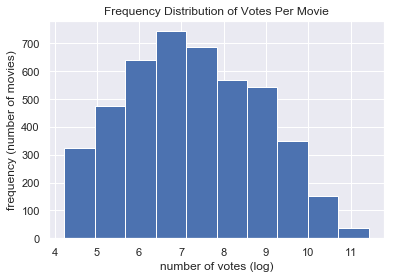

In [39]:
np.log(df.votes_per_movie).hist()
plt.title('Frequency Distribution of Votes Per Movie')
plt.xlabel('number of votes (log)')
plt.ylabel('frequency (number of movies)')

df.votes_per_movie.describe()

In [40]:
# Get the row of max value in votes_per_movie
df.loc[df['votes_per_movie'].idxmax()]['title']

'Forrest Gump'

**Findings**
- The distribution of votes per movie is skewed to the right, with mean (4522) larger than median (1334). There are outliers with large number of votes observed, which in our case, is 'Forrest Gump'.

### Money Matters: Could higher budget guarantee more positive revenue or ratings?
Budget as the key financing element that movie companies could decide in an early stage of a movie production. As the scatter plot showed that the movie budget has positive relationship with movie revenue. I'd like to also investigate whether high budget could also buy audience's preference.

In [41]:
# Correct budget values
def multiple_million(series):
    if len(str(series)) < 3:
        return series * 1000000
    else:
        return series
df['budget'] = df['budget'].apply(multiple_million)
df['revenue'] = df['revenue'].apply(multiple_million)

# Only four data whose budget values don't make sense left,
# I decided to manually check the info online and correct them accordingly
df.iloc[1453,3] = 11300000
df.iloc[4412,3] = 250000

### Higher budget often leads to higher revenue

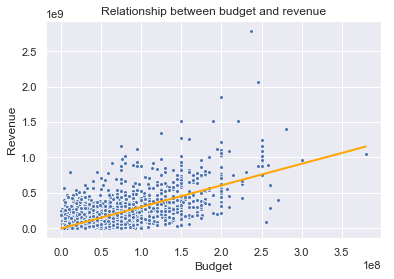

correlation:0.722, p-value0.000


In [42]:
# Plot the relationship between budget and revenue
sns.scatterplot(x = 'budget', y = 'revenue', data = df, s = 15)
plt.title('Relationship between budget and revenue')
plt.xlabel('Budget')
plt.ylabel('Revenue')

# perform a linear regrssion using np.polyfit()
slope, intercept = np.polyfit(df.budget, df.revenue, 1)
# Make theoretical line to plot
x = np.array([0, df.budget.max()])
y = slope * x + intercept
# add regression line
ax = plt.plot(x,y,c='orange',linewidth=2)

plt.show()

# Calculate correlation value
corr,p = scipy.stats.pearsonr(df.budget, df.revenue)
print ("correlation:%.3f, p-value%.3f" %(corr,p))

**Thought Process**

The strong correlation between budget and revenue suggested that they are very similar features. I would only keep 'budget' column when fitting a model later.

count    4.322000e+03
mean     3.687762e+07
std      4.231321e+07
min      1.000000e+06
25%      9.000000e+06
50%      2.200000e+07
75%      5.000000e+07
max      3.800000e+08
Name: budget, dtype: float64

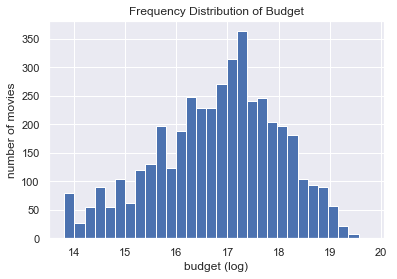

In [43]:
df = df[df['budget'] >= 1000000]

# log the budget value
ax = np.log(df.budget).hist(bins=30) 
plt.title('Frequency Distribution of Budget')
plt.xlabel('budget (log)')
plt.ylabel('number of movies')

df.budget.describe()

### Movie budget doesn't align with the audience preference

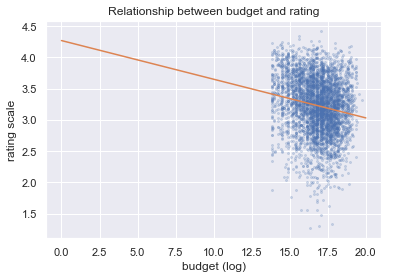

correlation:-0.167, p-value0.000


In [44]:
# plot the budget versus weighted rating
ax = plt.plot(np.log(df.budget),df.weighted_rating, 'o', markersize = 2, alpha = 0.2)
plt.title('Relationship between budget and rating')
plt.xlabel('budget (log)')
plt.ylabel('rating scale')

# perform a linear regrssion using np.polyfit()
slope, intercept = np.polyfit(np.log(df.budget), df.weighted_rating, 1)
# make theoretical line to plot
x = np.array([0, 20])
y = slope * x + intercept
# add regression line
ax = plt.plot(x,y)

plt.show()

# calculate correlation value
corr,p = scipy.stats.pearsonr(np.log(df.budget), df.weighted_rating)
print ("correlation:%.3f, p-value%.3f" %(corr,p))

### Production Sides: What's the influence of movie length and release timing  on ratings?

### Longer story attract audience more

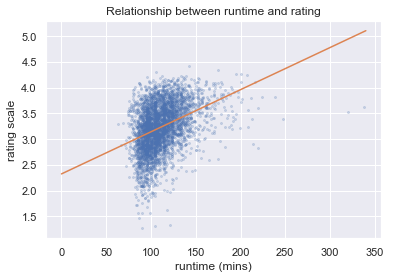

correlation:0.379, p-value0.000


In [45]:
# plot the revenue versus weighted rating
ax = plt.plot(df.runtime ,df.weighted_rating, 'o', markersize = 2, alpha = 0.2)
plt.title('Relationship between runtime and rating')
plt.xlabel('runtime (mins)')
plt.ylabel('rating scale')

# perform a linear regrssion using np.polyfit()
slope, intercept = np.polyfit(df.runtime, df.weighted_rating, 1)
# make theoretical line to plot
x = np.array([0, 340])
y = slope * x + intercept
# add regression line
ax = plt.plot(x,y)

plt.show()

# calculate correlation value
corr,p = scipy.stats.pearsonr(df.runtime, df.weighted_rating)
print ("correlation:%.3f, p-value%.3f" %(corr,p))
# 95% confidence in the relationship between features

### Timing seems to have less affect on movie ratings

Text(0, 0.5, 'ratings')

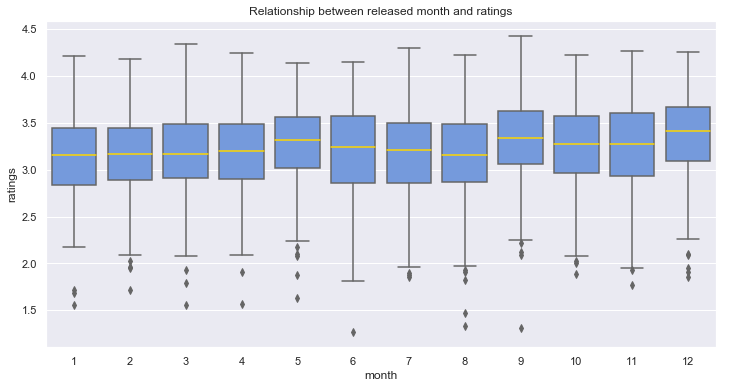

In [46]:
_ = plt.figure(figsize=(12,6))
_ = sns.boxplot(x = 'month', y = 'weighted_rating', data = df,color = 'cornflowerblue',medianprops={'color':'gold'} )
plt.title('Relationship between released month and ratings')
plt.xlabel('month')
plt.ylabel('ratings')

correlation:-0.153, p-value0.000


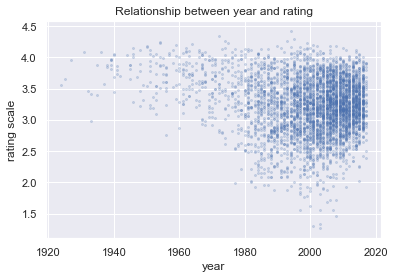

In [47]:
# plot the year versus weighted rating
ax = plt.plot(df.year ,df.weighted_rating, 'o', markersize = 2, alpha = 0.2)
plt.title('Relationship between year and rating')
plt.xlabel('year')
plt.ylabel('rating scale')

# Calculate correlation value
corr,p = scipy.stats.pearsonr(df.year ,df.weighted_rating)
print ("correlation:%.3f, p-value%.3f" %(corr,p))

**Thought Process**
1. The above graphs fail to capture the relationship between timing (month and year) and movie rating clearly. I would perform statistical tests to do more precise evaluation.

### Production Sides: What's the influence of production sites and studio on ratings?

In [48]:
df['production_countries'].value_counts(ascending = False)[:5]

United States of America    2978
United Kingdom               334
Germany                      172
France                       171
Canada                       169
Name: production_countries, dtype: int64

In [49]:
# select the top 5 countries with the most productions
top_countries = (df['production_countries'] == 'United States of America') | (df['production_countries']== 'United Kingdom') | (df['production_countries']== 'France') | (df['production_countries']== 'Germany')| (df['production_countries']== 'Canada')
countries_to_plot = df[top_countries]

#### Despite of being the movie-making capital, US's movies don't always get the highest rating score

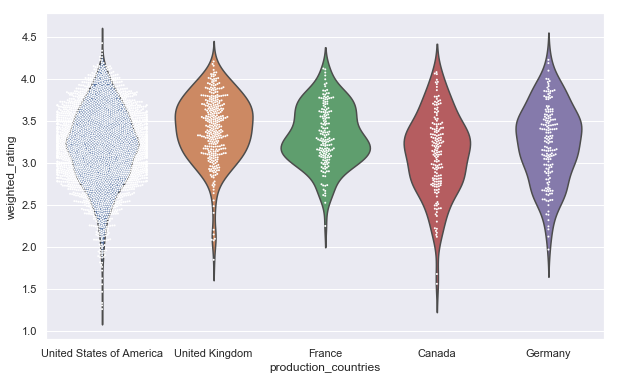

In [50]:
_ = plt.figure(figsize=(10,6))
_ = sns.violinplot(x="production_countries", y='weighted_rating', data = countries_to_plot, inner=None)
_ = sns.swarmplot(x="production_countries", y='weighted_rating', data = countries_to_plot, color="white", edgecolor="gray", size=2)

**Thought Process**
1. USA is the most dominant country. Its production numbers are way more than others and even nine times more than the second-ranking country, United Kingdom. 
2. Since the production numbers vary a lot. Only top 5 countries with the most productions are being considered when passing into the model.

### Studio size doesn't guarantee the movie rating 
Major film studios, known as 'Big Six', including Universal Pictures, Paramount Pictures,  Twentieth Century Fox Film Corporation, Warner Bros., Columbia Pictures, Walt Disney Pictures, contributed the most of movie productions in the industry. Yes, suprisinly, their movie raitngs don't seem to be higher than other studios.

In [51]:
# ignore missing observations and take only the 10 companies with the most productions
companies = df[df['production_companies'].map(len) > 0]['production_companies'].value_counts()[:10]

Universal Pictures                        316
Paramount Pictures                        314
Twentieth Century Fox Film Corporation    233
Columbia Pictures                         203
New Line Cinema                           159
Walt Disney Pictures                      126
Warner Bros.                              102
Miramax Films                              83
Columbia Pictures Corporation              79
United Artists                             78
Name: production_companies, dtype: int64

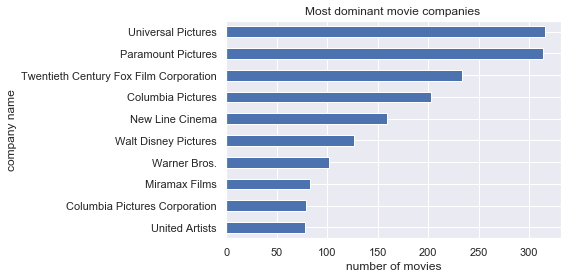

In [52]:
companies.sort_values().plot.barh()
plt.xlabel('number of movies')
plt.ylabel('company name')
plt.title('Most dominant movie companies ')
companies.sort_values(ascending = False)

In [53]:
def big_six(series):
    big_six = ['Universal Pictures', 'Paramount Pictures', 'Twentieth Century Fox Film Corporation', 'Warner Bros.', 'Columbia Pictures', 'Walt Disney Pictures']
    if series in big_six:
        return 1
    else:
        return 0
df['major_studio'] = df['production_companies'].apply(big_six)

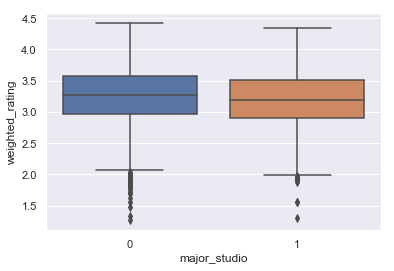

In [54]:
sns.boxplot(x = 'major_studio', y = 'weighted_rating', data = df)

### Genre Popularity: What's the relationship between genres and ratings
Based on the first chart showing that certain types of genres are more popular in terms of the production numbers, I would plot to check if the taste of movie companies aligned with the audience.

Originally, there are 20 genre types in the dataset. After merging subgenres into 10 major genres:
- `Drama`(Music/History)
- `Comedy`
- `Action`(War)
- `Thriller`(Mystery/Crime)
- `Adventure`(Western)
- `Horror`
- `Fantasy`(Science Fiction)
- `Family`
- `Animation`
- `Documentary`

*Note: TV Movie and Foreign are removed since both of them only have one data point

In [55]:
# Merge movie subgenres into major genres

def combine_genre(series):
    """Loop through the list of genres and replace the subgenres with the major types,
    and deleter two minor genres: 'TV Movie' and 'Foreign'
    """
    genre_dict = {'Music':'Drama','History':'Drama',
              'War':'Action', 
              'Crime':'Thriller','Mystery':'Thriller',
              'Western':'Adventure',
              'Science Fiction':'Fantasy'}
    try:
        for i in range(len(series)):
            if series[i] in genre_dict.keys():
                series[i] = genre_dict[series[i]]
            if series[i] == 'TV Movie':
                series.remove('TV Movie')
            if series[i] == 'Foreign':
                series.remove('Foreign')
    except IndexError:
        pass
    return list(set(series))

df['genres'] = df['genres'].apply(combine_genre)

In [56]:
# Reshape the genre columns to calculate their total production numbers

# Separate the list of genre types from genres column
genres_df = pd.concat([df['genres'].apply(pd.Series),df['id']],axis=1)
# Keep all genre types within the same column
genres_df = pd.melt(genres_df, id_vars='id',value_name='genre').drop(columns='variable').sort_values(by='id')
genres_merge = pd.merge(genres_df,df[['weighted_rating','id']], on = 'id').sort_values(by=['id'])
genres_merge = genres_merge[pd.notnull(genres_merge['genre'])]

# Count the production number of each genre
genre_count = pd.DataFrame(genres_merge.groupby('genre').count())
genre_count.reset_index(inplace = True)
genre_count.drop(columns = 'weighted_rating',inplace = True)
genre_count.columns = ['genre','count']
genre_count = genre_count.sort_values(by='count',ascending=True)

#### Filmmakers produce more Thriller and Drame movies

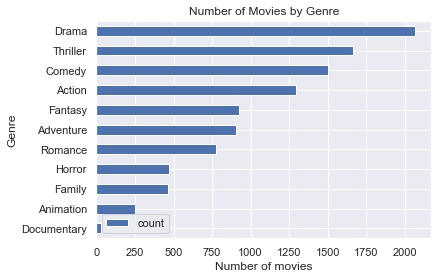

In [57]:
# Plot total number of movies vs genre
genre_count.plot.barh(x = 'genre', y = 'count')
plt.xlabel('Number of movies')
plt.ylabel('Genre')
plt.title('Number of Movies by Genre')

plt.show()

#### Thriller and Drama are easier to get high positive scores

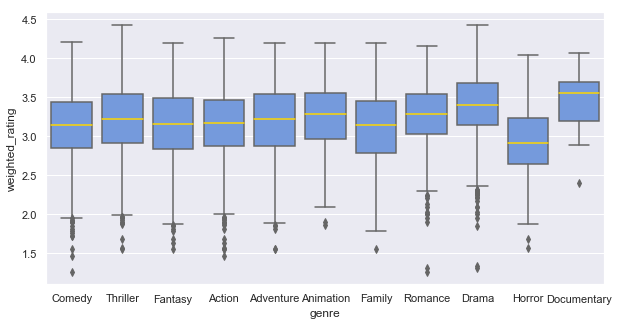

In [58]:
_ = plt.figure(figsize=(10,5))
_ = sns.boxplot(x = 'genre', y = 'weighted_rating', data = genres_merge,color = 'cornflowerblue',medianprops={'color':'gold'} )

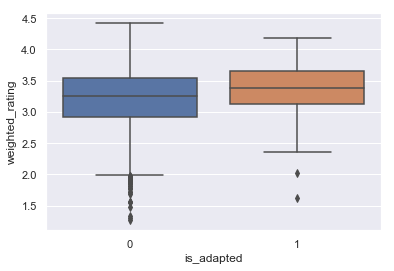

In [59]:
sns.boxplot(x = 'is_adapted', y = 'weighted_rating', data = df)

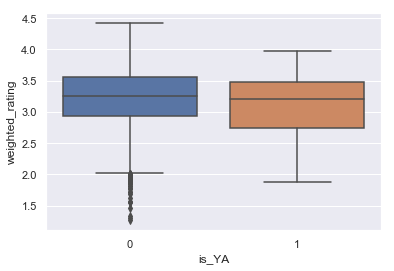

In [60]:
sns.boxplot(x = 'is_YA', y = 'weighted_rating', data = df)

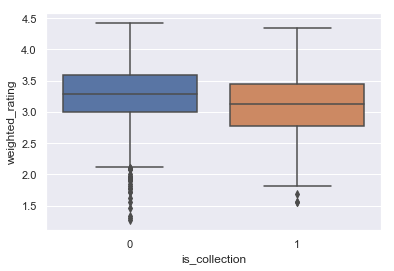

In [61]:
sns.boxplot(x = 'is_collection', y = 'weighted_rating', data = df)

## Correlation Matrix

In [62]:
df.columns

Index(['id', 'title', 'revenue', 'budget', 'is_collection', 'genres',
       'runtime', 'original_language', 'production_companies',
       'production_countries', 'cast', 'votes_per_movie', 'weighted_rating',
       'director', 'month', 'year', 'is_adapted', 'is_YA', 'major_studio'],
      dtype='object')

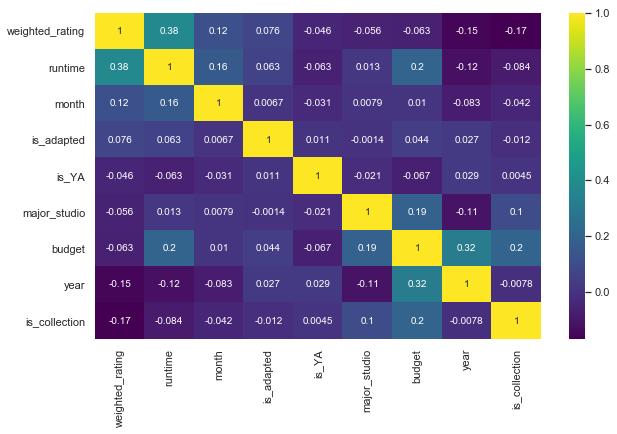

In [63]:
# select numerical variable
df_numeric = df[['weighted_rating','budget','is_collection','is_YA','is_adapted','runtime','month','year','major_studio']]

# plot coorelation matrix
k = 9 #number of variables for heatmap
cols = df_numeric.corr().nlargest(k, 'weighted_rating')['weighted_rating'].index
cm = df_numeric[cols].corr()
plt.figure(figsize=(10,6))
sns.heatmap(cm, annot=True, cmap = 'viridis')

If the Pearson correlation values are higher than 80, it suggests that the two input features are considered as highly-corelated features, and one should be removed. Yet, in my case, there no such situation observed.

# Statistical Tests
I used hypothesis tests on 'month' and 'year', both variables related to movie release timing, to examine which one has the real influence on movie scores.


ANOVA test would be used for examining 'month', while two-sample t-test would be used for 'year'. The key assumption behind both hypothesis tests is that the data should be normally distributed. 

### Examine if the data is normally distributed

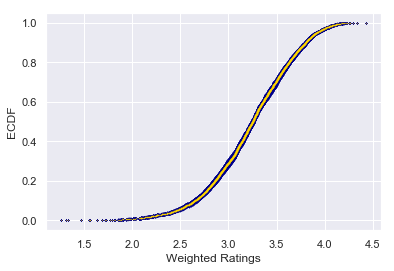

In [64]:
# Overlay the theoretical CDF of normal distribution with the empirical CDF of the real data
# to verify that the normal distribution describes the observed data

def ecdf(data):
    """Comput ECDF for a one-dimensiona array of measurements.
    """
    # Number of data points: n
    n = len(data)
    # x-data for the ECDF: x
    x = np.sort(data)
    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n
    
    return x, y

# Generate 50 bootstrape samples for normal distribution
for i in range(50):
    bs_sample = np.random.choice(df['weighted_rating'], size = len(df['weighted_rating']))
    # Plot a ECDF for each sample
    x, y = ecdf(bs_sample)
    _ = plt.plot(x, y, marker = '.',linestyle = 'none', c = 'darkblue', markersize = 0.5 )

    
# Plot ECDF for the original data
x, y = ecdf(df['weighted_rating'])
_ = plt.plot(x, y, marker = '.', linestyle = 'none',  c = 'gold', markersize = 0.5)

_ = plt.xlabel('Weighted Ratings')
_ = plt.ylabel('ECDF')

plt.show()

The CDF of a normal distribution computed from bootstrap samples overlay with the empirical CDF computed from real observations. It verifies the data of weighted_ratings is normally distributed, and meets the normality condition of hypothesis test.

#### Using ANOVA-Test to examine if movie scores differ among month
- Stating hypothesis
    - H0: The mean of weighted ratings are the same among movies released in 12 months.
    - H1: The mean of weighted ratings are different among movies released in 12 months.
- Deciding significance level
    - The significance level (α) is 0.05.

In [65]:
# dummy-encoding
df_new = df
df_new[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']] = pd.get_dummies(df['month'])[[1,2,3,4,5,6,7,8,9,10,11,12]]
df_new['intercept'] = 1
df_new.head()

,id,title,revenue,budget,is_collection,genres,runtime,original_language,production_companies,production_countries,...,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,intercept
0,862,Toy Story,373554033.0,30000000,1,"[Comedy, Animation, Family]",81.0,en,Pixar Animation Studios,United States of America,...,0,0,0,0,0,0,1,0,0,1
1,8844,Jumanji,262797249.0,65000000,0,"[Fantasy, Adventure, Family]",104.0,en,TriStar Pictures,United States of America,...,0,0,0,0,0,0,0,0,1,1
2,31357,Waiting to Exhale,81452156.0,16000000,0,"[Romance, Comedy, Drama]",127.0,en,Twentieth Century Fox Film Corporation,United States of America,...,0,0,0,0,0,0,0,0,1,1
3,949,Heat,187436818.0,60000000,0,"[Thriller, Drama, Action]",170.0,en,Regency Enterprises,United States of America,...,0,0,0,0,0,0,0,0,1,1
4,9091,Sudden Death,64350171.0,35000000,0,"[Thriller, Adventure, Action]",106.0,en,Universal Pictures,United States of America,...,0,0,0,0,0,0,0,0,1,1


In [66]:
# import module
import statsmodels.api as sm

# fit and summarize OLS model
mod = sm.OLS(df_new['weighted_rating'], df_new[['intercept','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']])
results = mod.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        weighted_rating   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     10.63
Date:                Thu, 07 Nov 2019   Prob (F-statistic):           1.44e-19
Time:                        15:50:53   Log-Likelihood:                -2627.9
No. Observations:                4322   AIC:                             5280.
Df Residuals:                    4310   BIC:                             5356.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.9716      0.006    467.229      0.000       2.959       2.984
Jan            0.1703      0.027      6.364      0.000       0.118       0.223
Feb            0.1857      0.025      7.550      0.000       0.137       0.234
Mar            0.2013      0.024      8.534      0.000       0.155       0.247
Apr            0.2071      0.024      8.515      0.000       0.159       0.255
May            0.3056      0.023     13.085      0.000       0.260       0.351
Jun            0.2303      0.022     10.430      0.000       0.187       0.274
Jul            0.2047      0.023      9.006      0.000       0.160       0.249
Aug            0.1704      0.022      7.710      0.000       0.127       0.214
Sep            0.3521      0.019     18.136      0.000       0.314       0.390
Oct            0.2753      0.021     12.830      0.000       0.233       0.317
Nov            0.2793      0.023     12.076      0.000       0.234       0.325
Dec            0.3895      0.020     19.713      0.000       0.351       0.428
==============================================================================
Omnibus:                      108.543   Durbin-Watson:                   1.705
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              117.001
Skew:                          -0.384   Prob(JB):                     3.92e-26
Kurtosis:                       3.245   Cond. No.                     2.78e+15
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.09e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

**Thought Process**: 

P-value(P >|t|) is less than the alpha value. Null hypothesis is rejected. There's statistically significant difference in scores between movies released in different months. Thus, we will pass the variable 'month' to the prediction machine since it might affect how people scores the movies.

#### Using t-test to examine if movie scores differ among years
Assuming that movies in the different periouds should receive different scores, we select two samples, one with movies released in the earlies and latest five years to perform independent t-test.

- Stating hypothesis
    - H0: The mean of weighted ratings are the **same** for two samples.
    - HA: The mean of weighted ratings are **different** for two samples.
- Deciding significance level
    - The significance level (α) is 0.05.

In [67]:
# sampling
previous_5_year = df[df['year'] > 1914 & (df['year'] < 1920)]['weighted_rating']
last_5_year = df[(df['year'] > 2012) & (df['year'] <= 2017)]['weighted_rating']

# independent t-test
from scipy import stats
t_stat, p = stats.ttest_ind(previous_5_year, last_5_year)
print ('statistics=%.3f , p=%.3f' %(t_stat,p))

# interpret via p-vaule
alpha = 0.05
if p > alpha:
    print('Accept null hypothesis that the means are equal.')
else:
    print('Reject the null hypothesis that the means are equal.')

statistics=-2.501 , p=0.012
Reject the null hypothesis that the means are equal.


**Thought Process**:

With p-value larger than alpha value, null hypothesis fails to be rejected. No statistically significant difference in scores between movies released in different years. Because the variable 'year' might be a less useful factor to predict movie scores, we dedcide to drop it.

# Feature Engineering
## Dummy Encoding
Before feeding the data into prediction models, we need to drop text variables that don't fit to our project scope and convert categorical variables to numerical with dummy encoding. 

In [68]:
df.columns

Index(['id', 'title', 'revenue', 'budget', 'is_collection', 'genres',
       'runtime', 'original_language', 'production_companies',
       'production_countries', 'cast', 'votes_per_movie', 'weighted_rating',
       'director', 'month', 'year', 'is_adapted', 'is_YA', 'major_studio',
       'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct',
       'Nov', 'Dec', 'intercept'],
      dtype='object')

In [69]:
# only keep variables that will be fed into the model
df_2 = df[['budget', 'is_collection', 'genres',
       'runtime', 'original_language',
       'production_countries', 'cast', 'votes_per_movie', 'weighted_rating',
       'director', 'month', 'is_adapted', 'is_YA', 'major_studio']]

In [70]:
# for the column 'director', 'production_companies', 'production_countries', 'original_language'
# convert the values with less occurence to 'Others'
def convert_to_others(df, col, x, num):
    top = df[col].value_counts()[:num]
    if x in top:
        return x
    if x not in top:
        return 'Others'
    
df_2.loc[:,'director'] = df_2['director'].apply(lambda x: convert_to_others(df_2, 'director', x, 10))
df_2.loc[:,'production_countries'] = df_2['production_countries'].apply(lambda x: convert_to_others(df_2, 'production_countries', x, 5))
df_2.loc[:,'original_language'] = df_2['original_language'].apply(lambda x: convert_to_others(df_2, 'original_language', x, 5))

/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [71]:
# get dummy variables 
columns = ['director','production_countries', 'original_language']
prefix_dic = {'director': 'director','production_countries':'country','original_language': 'language'}
df_dummy = pd.get_dummies(df_2, columns = columns, prefix = prefix_dic)

In [72]:
# drop column 'Others' from the dataframe
df_dummy.drop(columns = ['director_Others', 'language_Others', 'country_Others'], inplace = True)

In [73]:
# dummy encoding for genre
df_genre = pd.get_dummies(pd.Series(df['genres']).apply(pd.Series).stack()).sum(level=0).drop(columns = 'Documentary')

In [74]:
# for 'cast' column, we only select top 30 movie stars with the most appearance 
# and convert the rest to 'Others'
# compute the top casts
from collections import Counter
def occurence(Series):
    cnt = Counter()
    
    def cast_dict(x):
        cast_dict = Counter()
        for cast in x:
            cast_dict[cast] += 1
        return cast_dict
    for d in Series.apply(cast_dict):
        cnt += d
    return cnt

In [75]:
top_cast = sorted(occurence(df.cast), key = occurence(df.cast).get, reverse = True) [:10]
print (top_cast)

['Robert De Niro', 'Nicolas Cage', 'Bruce Willis', 'Tom Hanks', 'Johnny Depp', 'Matt Damon', 'Sylvester Stallone', 'Samuel L. Jackson', 'Tom Cruise', 'Harrison Ford']


In [76]:
# iterate through each list
# turn each list into a set
# compare the set with the set(top_cast)
# return the elements appearing in both set

def compare_two_sets(x):
    if bool(set(x) & set(top_cast)):
        return list(set(x) & set(top_cast))
    else:
        return ['Others']
df_2.loc[:,'cast'] = df_2['cast'].apply(compare_two_sets)

In [77]:
# dummy encoding for cast
df_cast = pd.get_dummies(pd.Series(df_2['cast']).apply(pd.Series).stack()).sum(level=0).drop(columns = 'Others')

In [78]:
# dummy encoding for month
df_month = pd.get_dummies(df['month'], drop_first = True)
df_month.rename(columns = {2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}, inplace = True)

In [79]:
# concate the dataframe
df_clean = pd.concat([df_dummy, df_cast, df_genre, df_month], axis = 1).drop(columns = ['genres','cast','month'])

In [80]:
df_clean.head()

,budget,is_collection,runtime,votes_per_movie,weighted_rating,is_adapted,is_YA,major_studio,director_Alfred Hitchcock,director_Clint Eastwood,...,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,30000000,1,81.0,66008,3.887294,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,65000000,0,104.0,26060,3.236489,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,16000000,0,127.0,2981,2.879907,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3,60000000,0,170.0,27895,3.839837,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,35000000,0,106.0,4423,3.009175,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


In [81]:
df_clean.shape

(4322, 59)

In [82]:
# Ensure there no NaN values before fitting the model
df_clean.dropna(axis = 0, how = 'any', inplace = True)

In [83]:
df_clean.isna().sum().sum()

0

### Final Check Correlation among Features
After data transformation process using dummy encoding, I re-check the correlation values among variables before passing the data to models.

In [84]:
# find highly correlated features with Pearson Correlation higher than 0.7
corr_maxtric = df_clean.corr().abs()
cols = df_clean.columns
correlated_pairs = set()
for i in range(len(cols)):
    for j in range(i):
        if corr_maxtric.iloc[i,j] > 0.7:
            correlated_pairs.add((cols[i],cols[j],corr_maxtric.iloc[i,j]))
print (pd.DataFrame(correlated_pairs))

Empty DataFrame
Columns: []
Index: []


# Machine Learning Prediction

## Decision Tree

In [85]:
#  Import 'r2_score'
from sklearn.metrics import r2_score
from sklearn.model_selection import ShuffleSplit

In [86]:
def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    
    #   Calculate the performance score between 'y_true' and 'y_predict'
    score = r2_score(y_true, y_predict)
    
    # Return the score
    return score

In [87]:
# split dataset in features and target variable
feature_cols = list(df_clean.columns)
feature_cols.remove('weighted_rating')
x = df_clean[feature_cols] # features
y = df_clean['weighted_rating'] # target variable

In [88]:
# Import 'make_scorer', 'DecisionTreeRegressor', and 'GridSearchCV'
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

def fit_model_dt(x, y):
    """ Performs grid search over the 'max_depth' parameter for a 
        decision tree regressor trained on the input data [X, y]. """
    
    # Create cross-validation sets from the training data
    cv_sets = ShuffleSplit(n_splits=5, train_size = 0.20, random_state = 0)

    #  Create a decision tree regressor object
    regressor = DecisionTreeRegressor()

    #  Create a dictionary for the parameter 'max_depth' with a range from 1 to 10
    params = {'max_depth':range(1,11)}

    #  Transform 'performance_metric' into a scoring function using 'make_scorer' 
    scoring_fnc = make_scorer(performance_metric)

    #   Create the grid search cv object --> GridSearchCV()
    # Make sure to include the right parameters in the object:
    # (estimator, param_grid, scoring, cv) which have values 'regressor', 'params', 'scoring_fnc', and 'cv_sets' respectively.
    grid = GridSearchCV(regressor, params, scoring_fnc, cv=cv_sets)

    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(x, y)
    
    # Return the optimal model after fitting the data
    return grid.best_estimator_

In [89]:
# Get the best parameter
fit_model_dt(x, y)

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1788: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


DecisionTreeRegressor(criterion='mse', max_depth=4, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [90]:
# Split the dataframe into two 80% for training and 20% testing
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [116]:
# Train regression tree model
dt = DecisionTreeRegressor(max_depth=4)
dt.fit(x_train, y_train)
# Predict the response for test dataset
y_pred_dt = dt.predict(x_test)

In [117]:
# Performance on training data
r2_score(y_train, dt.predict(x_train))

0.4065637129682883

In [118]:
# Performance on test data
r2_score(y_test, y_pred_dt)

0.3446569408727942

In [94]:
dt.feature_importances_

array([0.11030713, 0.02760448, 0.09260292, 0.48184469, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.28764079, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        ])

In [95]:
list(zip(feature_cols, dt.feature_importances_))

[('budget', 0.11030712542426006),
 ('is_collection', 0.027604477415886883),
 ('runtime', 0.09260291859458526),
 ('votes_per_movie', 0.48184468820681847),
 ('is_adapted', 0.0),
 ('is_YA', 0.0),
 ('major_studio', 0.0),
 ('director_Alfred Hitchcock', 0.0),
 ('director_Clint Eastwood', 0.0),
 ('director_Martin Scorsese', 0.0),
 ('director_Oliver Stone', 0.0),
 ('director_Ridley Scott', 0.0),
 ('director_Robert Zemeckis', 0.0),
 ('director_Steven Soderbergh', 0.0),
 ('director_Steven Spielberg', 0.0),
 ('director_Tim Burton', 0.0),
 ('director_Woody Allen', 0.0),
 ('country_Canada', 0.0),
 ('country_France', 0.0),
 ('country_Germany', 0.0),
 ('country_United Kingdom', 0.0),
 ('country_United States of America', 0.0),
 ('language_en', 0.0),
 ('language_es', 0.0),
 ('language_fr', 0.0),
 ('language_hi', 0.0),
 ('language_ja', 0.0),
 ('Bruce Willis', 0.0),
 ('Harrison Ford', 0.0),
 ('Johnny Depp', 0.0),
 ('Matt Damon', 0.0),
 ('Nicolas Cage', 0.0),
 ('Robert De Niro', 0.0),
 ('Samuel L. Jackso

## Random Forest

In [96]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor()
rfr.fit(x_train, y_train)
rfr.score(x_train, y_train) # yeilds R-squared value

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.904345992231273

In [97]:
# Import 'make_scorer', 'DecisionTreeRegressor', and 'GridSearchCV'
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

def fit_model_rfr(x, y):
    """ Performs grid search over the 'max_depth' parameter for a 
        decision tree regressor trained on the input data [X, y]. """
    
    # Create cross-validation sets from the training data
    # sklearn version 0.18: ShuffleSplit(n_splits=10, test_size=0.1, train_size=None, random_state=None)
    # sklearn versiin 0.17: ShuffleSplit(n, n_iter=10, test_size=0.1, train_size=None, random_state=None)
    cv_sets = ShuffleSplit(n_splits=5, train_size = 0.20, random_state = 0)

    #  Create a decision tree regressor object
    rfr = RandomForestRegressor()

    #  Create a dictionary for the parameter 'max_depth' with a range from 1 to 10
    params = {'max_depth':range(1,11)}

    #  Transform 'performance_metric' into a scoring function using 'make_scorer' 
    scoring_fnc = make_scorer(performance_metric)

    #   Create the grid search cv object --> GridSearchCV()
    # Make sure to include the right parameters in the object:
    # (estimator, param_grid, scoring, cv) which have values 'regressor', 'params', 'scoring_fnc', and 'cv_sets' respectively.
    grid = GridSearchCV(rfr, params, scoring_fnc, cv=cv_sets)

    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(x, y)
 #   print "Parameter 'max_depth' is {} for the optimal model.".format(grid.get_params() )

    # Return the optimal model after fitting the data
    return grid.best_estimator_

In [98]:
fit_model_rfr(x, y)

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1788: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimator

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The de

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [99]:
rfr = RandomForestRegressor(max_depth=7)
# train devision tree classifer
rfr.fit(x_train, y_train)
# predict the response for test dataset
y_pred = rfr.predict(x_test)

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [100]:
# performance on training data
r2_score(y_train, rfr.predict(x_train))

0.6136262211885304

In [101]:
# performance on test data
r2_score(y_test, y_pred)

0.4727894914009436

In [121]:
list(zip(feature_cols, rfr.feature_importances_))

[('budget', 0.14497985026483037),
 ('is_collection', 0.03162903843372648),
 ('runtime', 0.11892773063507749),
 ('votes_per_movie', 0.41162548400756005),
 ('is_adapted', 0.0023057181732954873),
 ('is_YA', 0.001229465996693221),
 ('major_studio', 0.005059530532898692),
 ('director_Alfred Hitchcock', 0.00019246685751997083),
 ('director_Clint Eastwood', 0.0),
 ('director_Martin Scorsese', 5.6352118638213435e-05),
 ('director_Oliver Stone', 0.000206930222107543),
 ('director_Ridley Scott', 0.0),
 ('director_Robert Zemeckis', 0.0),
 ('director_Steven Soderbergh', 0.0),
 ('director_Steven Spielberg', 0.0003124581339283077),
 ('director_Tim Burton', 4.795368104355616e-05),
 ('director_Woody Allen', 0.0004419336483714617),
 ('country_Canada', 0.00026736501097771525),
 ('country_France', 0.003985062801207218),
 ('country_Germany', 6.100193653198436e-06),
 ('country_United Kingdom', 0.0022116166834235847),
 ('country_United States of America', 0.007878697547200313),
 ('language_en', 0.0038488174

# Conclusion

In this project, I use decision tree regressor and random forest regressor to predict the weighted values of movie ratings. For both models, ,'budget','runtime','votes_per_movie', 'drama' serve as the more important feature for the prediction accuracy, with 'votes_per_movie' being the most crucial one. The popularity of a movie highly depends on how many audience watch it. 

**What to improve in the future**
1. When trying to simplify features with many categories, besides of qualitative categorization, it's also worth trying to aggregate those categories based on whether they have similar values of target variables. For example, for genre, 'documentary', 'horror', and 'drama' should stay as individual category since their average values of weighted rating distinguish from others. But for the rest of genre types, they can be combined into one group since they perform similarily.
2. When extracting new features, such as whether the movie is adapted from novels and whether it is a Young Adult fiction, the information from the dataset could be better verified with other resources to ensure the data is valid. 